In [1]:
# 필요한 라이브러리 불러오기
import io
import random
from pathlib import Path

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import h5py
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.nn import Linear, CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import get_model
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.transforms.v2 import (
    ToImage,
    Compose,
    ToDtype,
    Normalize,
    Resize,
    ColorJitter,
    RandomHorizontalFlip,
    RandomGrayscale,
    GaussianBlur,
)
from torchmetrics import MeanMetric, Accuracy

In [2]:
# ResNet50 모델 불러오기 (사전 학습된 가중치 사용)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# 마지막 레이어 수정 (2개의 클래스 분류를 위한 출력 레이어)
model.fc = nn.Linear(in_features=2048, out_features=2)

# 모델 요약 정보 출력
from torchinfo import summary
print(summary(model))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [3]:
# 학습에 사용할 장치와 이미지 크기 설정, 데이터 경로 설정
DEVICE = "cuda"
IMAGE_SIZE = 128
DATA_PATH = Path("/kaggle/input/isic-2024-challenge")

In [4]:
# 데이터셋 클래스 정의
class ISICDataset(Dataset):
    def __init__(self, images, meta, normalize=True, augment=False) -> None:
        self.images = images  # 이미지 데이터
        self.meta = meta  # 메타데이터 (레이블 정보)
        
        # 이미지 전처리 파이프라인 구성
        transform_list = [
            ToImage(),  # 이미지를 PIL 형태로 변환
            Resize(IMAGE_SIZE, antialias=True),  # 이미지 크기 조정
            ToDtype(torch.float32, scale=True),  # 데이터 타입 변환 및 스케일링
        ]
        if normalize:
            transform_list.append(
                Normalize(
                    mean=[0.6784, 0.4978, 0.4090],  # 평균값으로 정규화
                    std=[0.0554, 0.0620,  0.0575],  # 표준편차로 정규화
                ),
            )
        if augment:
            # 데이터 증강 기법 추가 (밝기, 대조, 채도, 색조 변화, 가로 반전, 그레이스케일, 가우시안 블러)
            transform_list += [
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
                RandomHorizontalFlip(),
                RandomGrayscale(),
                GaussianBlur(kernel_size=3),
            ]
        self.transform = Compose(transform_list)  # 전처리 파이프라인 결합

    def __len__(self) -> int:
        return len(self.meta)  # 데이터셋의 길이 반환

    def __getitem__(self, index: int):
        sample = self.meta.iloc[index]  # 인덱스에 해당하는 샘플 선택
        image = Image.open(io.BytesIO(self.images[sample["isic_id"]][()]))  # 이미지를 메모리에서 불러옴
        label = sample["target"]  # 레이블 추출
        return self.transform(image), torch.tensor(label, dtype=torch.int64)  # 전처리된 이미지와 레이블 반환

In [5]:
# 학습 및 평가를 위한 트레이너 클래스 정의
class Trainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model.to(DEVICE)  # 모델을 GPU로 이동
        self.criterion = criterion.to(DEVICE)  # 손실 함수를 GPU로 이동
        self.optimizer = optimizer  # 옵티마이저 설정
        self.accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)  # 정확도 계산을 위한 객체 생성
        self.metrics = {  # 손실과 정확도를 기록할 메트릭 정의
            x: MeanMetric().to(DEVICE) 
            for x in ("loss", "accuracy", "val_loss", "val_accuracy")
        }
        self.history = pd.DataFrame(columns=list(self.metrics), index=pd.Index([], name="epoch"))  # 학습 이력 저장을 위한 데이터프레임 생성
        
    # 모델 학습 함수 정의
    def fit(self, train_loader, val_loader, epochs, verbose):
        for epoch in range(1, epochs + 1):  # 각 에포크마다 반복
            print(f"Epoch {epoch:04d}/{epochs:04d}")
            self.train_one_epoch(train_loader, verbose)  # 한 에포크 동안 학습
            self.validate_one_epoch(val_loader, verbose)  # 한 에포크 동안 검증
            self.update_history(epoch)  # 학습 이력 업데이트
            
    # 한 에포크 동안 학습을 진행하는 함수
    def train_one_epoch(self, loader, verbose):
        model.train()  # 모델을 학습 모드로 설정
        
        # 배치 단위로 학습 진행
        with tqdm(total=len(loader), disable=not verbose) as progress_bar:
            for batch in loader:
                images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)  # 이미지와 레이블을 GPU로 이동
                self.optimizer.zero_grad()  # 옵티마이저 초기화
                predict = self.model(images)  # 예측값 계산
                loss = self.criterion(predict, labels)  # 손실 계산
                loss.backward()  # 역전파 수행
                self.optimizer.step()  # 옵티마이저 업데이트
                
                # 메트릭 업데이트
                self.metrics["loss"].update(loss)
                self.metrics["accuracy"].update(self.accuracy(predict, labels))
                progress_bar.set_description(
                    f"loss {self.metrics['loss'].compute():.3f} "
                    f"accuracy {self.metrics['accuracy'].compute():.3f}"
                )
                progress_bar.update(1)
            
    # 한 에포크 동안 검증을 진행하는 함수
    def validate_one_epoch(self, loader, verbose):
        model.eval()  # 모델을 평가 모드로 설정
        
        # 배치 단위로 검증 진행
        with tqdm(total=len(loader), disable=not verbose) as progress_bar, torch.no_grad():
            for batch in loader:
                images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)  # 이미지와 레이블을 GPU로 이동
                predict = self.model(images)  # 예측값 계산
                loss = self.criterion(predict, labels)  # 손실 계산

                # 메트릭 업데이트
                self.metrics["val_loss"].update(loss)
                self.metrics["val_accuracy"].update(self.accuracy(predict, labels))
                progress_bar.set_description(
                    f"val_loss {self.metrics['val_loss'].compute():.3f} "
                    f"val_accuracy {self.metrics['val_accuracy'].compute():.3f}"
                )
                progress_bar.update(1)
                
    # 학습 이력 업데이트 함수
    def update_history(self, epoch: int) -> None:
        metrics = {}

        # 각 메트릭의 값을 기록하고 초기화
        for metric_name, metric in self.metrics.items():
            value = metric.compute().item()
            print(f"{metric_name}: {value:.3f}")
            metrics[metric_name] = value
            metric.reset()

        self.history.loc[epoch] = metrics  # 데이터프레임에 저장

In [6]:
# 데이터 경로 설정
DATA_PATH = Path("/kaggle/input/isic-2024-challenge")

# 데이터 불러오기 및 전처리
data = pd.read_csv(
    DATA_PATH.joinpath("train-metadata.csv"),
    usecols=["isic_id", "target"],
)

# 이미지 데이터 불러오기
images = h5py.File(DATA_PATH.joinpath("train-image.hdf5"), "r")  # 이미지 데이터 로드

# 악성 데이터와 음성 데이터 분리
malignant_data = data[data["target"] == 1]  # 악성 데이터 (약 300개)
benign_data = data[data["target"] == 0]  # 음성 데이터 (약 4만 개)

# 학습 데이터셋: 악성 데이터 증강 적용
train_malignant_dataset = ISICDataset(images, malignant_data, augment=True)  # 악성 데이터 증강
train_benign_dataset = ISICDataset(images, benign_data, augment=False)  # 음성 데이터 그대로 유지

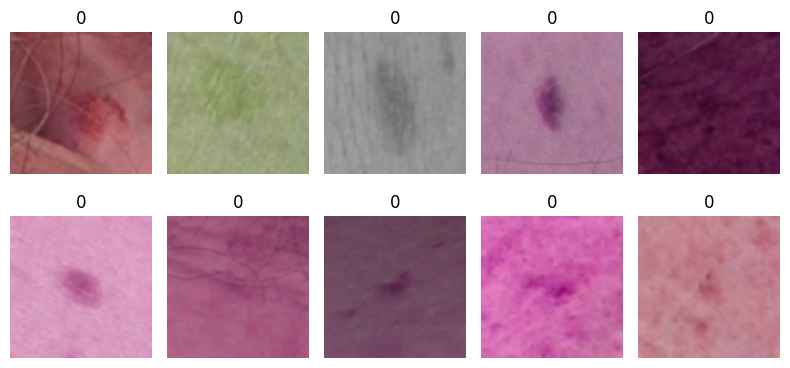

In [7]:
# 일부 이미지를 시각화
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
axes = axes.flatten()

dataset = ISICDataset(images, data, normalize=False, augment=True)  # 데이터셋 객체 생성
indices = random.choices(range(len(dataset)), k=len(axes))  # 랜덤 인덱스 선택

for index, ax in zip(indices, axes):
    image, label = dataset[index]

    ax.imshow(to_pil_image(image))
    ax.set_title(label.item())
    ax.axis("off")
    
figure.tight_layout()
figure.show()

In [8]:
from torch.utils.data import ConcatDataset  # ConcatDataset 임포트

# 데이터셋 합치기
train_dataset = ConcatDataset([train_malignant_dataset, train_benign_dataset])

# 검증 데이터셋 생성 (일반적으로 원본 데이터를 사용)
train_data, val_data = train_test_split(data, test_size=0.25, shuffle=True)
val_dataset = ISICDataset(images, val_data, augment=False)

# 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


In [9]:
# ResNet50 모델 불러오기 및 수정
model = get_model("resnet50", weights=None)
model.load_state_dict(torch.load("/root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth"))

# 마지막 레이어 수정 (2개의 클래스 분류를 위한 출력 레이어)
model.fc = Linear(in_features=2048, out_features=2)
print(summary(model))

# 옵티마이저와 손실 함수 정의
optimizer = AdamW(model.parameters())
criterion = CrossEntropyLoss()

# 트레이너 객체 생성 및 학습 수행
trainer = Trainer(model, criterion, optimizer)
trainer.fit(train_loader, val_loader, epochs=10, verbose=True)

/tmp/ipykernel_36/3927929967.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth")

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.007
accuracy: 0.999
val_loss: 0.029
val_accuracy: 0.999
Epoch 0002/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.002
accuracy: 1.000
val_loss: 0.072
val_accuracy: 0.999
Epoch 0003/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.038
val_accuracy: 0.999
Epoch 0004/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.002
accuracy: 1.000
val_loss: 0.054
val_accuracy: 0.999
Epoch 0005/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.464
val_accuracy: 0.999
Epoch 0006/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.063
val_accuracy: 0.999
Epoch 0007/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.652
val_accuracy: 0.999
Epoch 0008/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.099
val_accuracy: 0.999
Epoch 0009/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.053
val_accuracy: 0.999
Epoch 0010/0010


  0%|          | 0/25067 [00:00<?, ?it/s]

  0%|          | 0/6267 [00:00<?, ?it/s]

loss: 0.001
accuracy: 1.000
val_loss: 0.031
val_accuracy: 0.999


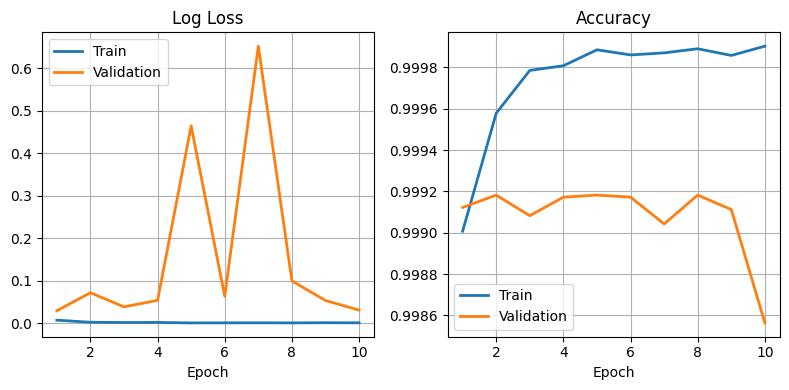

In [10]:
# 학습 이력 시각화
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
history = trainer.history

axes[0].plot(history.index, history["loss"], linewidth=2, label="Train")
axes[0].plot(history.index, history["val_loss"], linewidth=2, label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_title("Log Loss")
axes[0].legend()
axes[0].grid()

axes[1].plot(history.index, history["accuracy"], linewidth=2, label="Train")
axes[1].plot(history.index, history["val_accuracy"], linewidth=2, label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_title("Accuracy")
axes[1].legend()
axes[1].grid()

figure.tight_layout()

In [11]:
# 테스트 데이터 불러오기
data = pd.read_csv(
    DATA_PATH.joinpath("test-metadata.csv"),
    usecols=["isic_id"],
)
data["target"] = 0
images = h5py.File(DATA_PATH.joinpath("test-image.hdf5"))

# 테스트 데이터셋 및 로더 생성
test_dataset = ISICDataset(images, data)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
)

# 테스트 데이터에 대해 예측 수행
predict_list = []

for batch in test_loader:
    images = batch[0].to(DEVICE)
    predict = softmax(model(images), dim=1)[:, 1]
    predict_list += predict.tolist()

# 예측 결과를 CSV 파일로 저장
data["target"] = predict_list
data.to_csv("submission.csv", index=False)
data.head()

,isic_id,target
0,ISIC_0015657,1.125259e-26
1,ISIC_0015729,1.157631e-12
2,ISIC_0015740,6.282138e-17
